In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers
from tensorflow.keras import backend as bck

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4.2)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Training parameters and variables

In [3]:
histories = {}
epochs = 100
batch_size = 1024

## Downloading and splitting data

This dataset does not provide test part so we'll split training data into 70-15-15 as train, validate and test parts.

In [4]:
(dataset_train_raw, dataset_validate_raw, dataset_test_raw), info = tfds.load(
    name="eurosat/rgb",
    split=[
        tfds.Split.TRAIN.subsplit(tfds.percent[:70]),
        tfds.Split.TRAIN.subsplit(tfds.percent[70:85]),
        tfds.Split.TRAIN.subsplit(tfds.percent[85:])
    ],
    with_info=True,
    as_supervised=True
)

print(info)
print("Train:   ", len(list(dataset_train_raw)))
print("Validate:", len(list(dataset_validate_raw)))
print("Test:    ", len(list(dataset_test_raw)))


tfds.core.DatasetInfo(
    name='eurosat',
    version=0.0.1,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat
',
    urls=['https://github.com/phelber/eurosat'],
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
       

In [5]:
class_names = ["annual crop", "forest", "herbaceous vegetation", "highway", "industrial", "pasture", "permanent crop", "residential", "river", "sea or lake"]

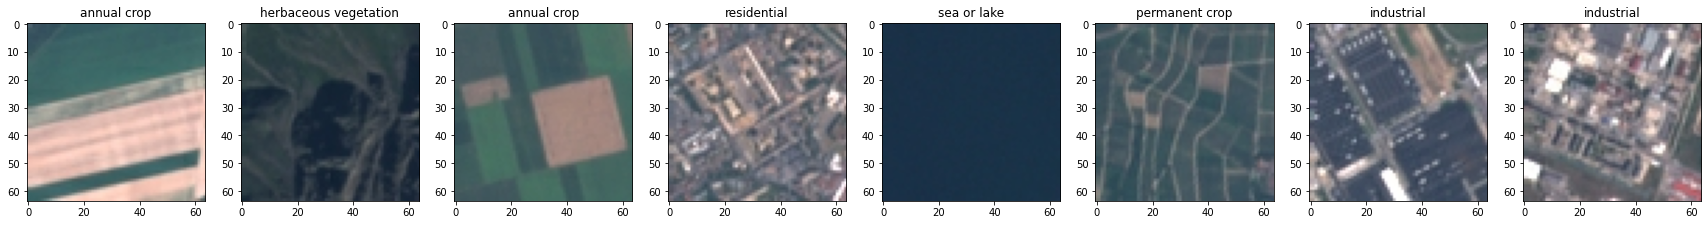

In [6]:
sample_size = 8

plt.figure(figsize=(30, 8))

for index, (image, label) in enumerate(dataset_train_raw.take(sample_size)):
    
    plt.subplot(1, sample_size, index + 1)
    plt.imshow(image)
    plt.title(class_names[label])

## Preprocessing data

In [7]:
def encode(image, label):
    
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    label = tf.one_hot(label, depth=len(class_names))
    
    return image, label
    
data_train = dataset_train_raw.map(lambda image, label: encode(image, label)).cache()
data_validate = dataset_validate_raw.map(lambda image, label: encode(image, label)).cache()
data_test = dataset_test_raw.map(lambda image, label: encode(image, label)).cache()

print(data_train)

<CacheDataset shapes: ((64, 64, 3), (10,)), types: (tf.float32, tf.float32)>


## Define Neural Network base architecture

In [8]:
model = models.Sequential()

# Conv 32 block; kernel 3x3
model.add(layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(64, 64, 3)))
model.add(layers.Conv2D(32, (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(2, 2))

# Conv 64 block; kernel 3x3
model.add(layers.Conv2D(64, (3,3), activation="relu", padding="same"))
model.add(layers.Conv2D(64, (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(2, 2))

# Conv 128 block; kernel 3x3
model.add(layers.Conv2D(128, (3,3), activation="relu", padding="same"))
model.add(layers.Conv2D(128, (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(2, 2))

# Latent space
model.add(layers.Flatten())

# Classifier
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       7

### Define compiler

In [9]:
model.compile(
    optimizer="nadam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## Create Base Model
### Model evaluation before training

In [ ]:
loss, acc = model.evaluate(data_test.batch(32))

print("Evaluation with randomly initialized weights")
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))

### Training baseline ANN model

In [ ]:
history = model.fit(
    data_train.shuffle(10_000).batch(batch_size),
    epochs=epochs,
    validation_data=data_validate.batch(batch_size)
)

histories["baseline"] = history

In [ ]:
def plot_history(history):
    
  plt.figure(figsize=(10, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history["loss"], label="loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.legend()
  plt.title("Loss")

  plt.subplot(1, 2, 2)
  plt.plot(history.history["accuracy"], label="accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  plt.legend()
  plt.title("Accuracy")

  plt.show()
  plt.close()

### Evaluation of training process

#### Significant overfitting, we proceed with next steps to deal with that. Let's start with Dropout layers

In [ ]:
plot_history(history)

loss, acc = model.evaluate(data_test.batch(32))
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))

## Reduce overfitting - step 1
### Dropout layers

In [ ]:
# from IPython.display import display_html
# def restartkernel() :
#     display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
    
# restartkernel()

# sleep(5)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers
from tensorflow.keras import backend as bck

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4.2)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [15]:
model = models.Sequential()

# Conv 32 block; kernel 3x3
model.add(layers.Conv2D(32, (3,3), activation="swish", padding="same", input_shape=(64, 64, 3)))
model.add(layers.Conv2D(32, (3,3), activation="swish", padding="same"))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.2))

# Conv 64 block; kernel 3x3
model.add(layers.Conv2D(64, (3,3), activation="swish", padding="same"))
model.add(layers.Conv2D(64, (3,3), activation="swish", padding="same"))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.3))

# Conv 128 block; kernel 3x3
model.add(layers.Conv2D(128, (3,3), activation="swish", padding="same"))
model.add(layers.Conv2D(128, (3,3), activation="swish", padding="same"))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.4))

# Latent space
model.add(layers.Flatten())

# Classifier
model.add(layers.Dense(128, activation="swish"))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)       

### Preprocessing

In [16]:
data_train = dataset_train_raw.map(lambda image, label: encode(image, label)).cache()
data_validate = dataset_validate_raw.map(lambda image, label: encode(image, label)).cache()
data_test = dataset_test_raw.map(lambda image, label: encode(image, label)).cache()

### Training ANN

In [17]:
model.compile(
    optimizer="nadam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
history = model.fit(
    data_train.shuffle(10_000).batch(batch_size),
    epochs=epochs,
    validation_data=data_validate.batch(batch_size)
)

histories["dropout"] = history

Epoch 1/100


ResourceExhaustedError:  OOM when allocating tensor with shape[1024,128,16,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_1/conv2d_11/Sigmoid (defined at <ipython-input-18-fb9788e31aa1>:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_67278]

Function call stack:
train_function


In [ ]:
plot_history(history)

loss, acc = model.evaluate(data_test.batch(32))
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))

## Reduce overfitting - step 2
#### Data Augmentation

In [ ]:
data_train = dataset_train_raw.map(lambda image, label: encode(image, label)).cache()
data_train = data_train.map(lambda image: )
data_validate = dataset_validate_raw.map(lambda image, label: encode(image, label)).cache()
data_test = dataset_test_raw.map(lambda image, label: encode(image, label)).cache()